In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna import Trial
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import mean_squared_error

from imblearn.under_sampling import NearMiss

from xgboost import XGBClassifier

from xgboost import plot_importance
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , ExtraTreesClassifier , VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV , cross_val_score , StratifiedKFold , learning_curve

c:\Users\abeta\anaconda3\envs\forcompe\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")
df_ = df.copy()
test_ = test.copy()

In [3]:
#特徴量作成
df_['DAYS_BIRTH'] = df_['DAYS_BIRTH']//-360

df_['EXT_23_sum'] = (df_['EXT_SOURCE_2'] + df_['EXT_SOURCE_3'])
df_['EXT_12_sum'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_2'])
df_['EXT_13_sum'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_3'])
df_['EXT_123_sum'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_2'] + df_['EXT_SOURCE_3'])

#勤続日数/年齢日数
df_['DAYS_EMPLOYED_PERC'] = df_['DAYS_EMPLOYED'] / df_['DAYS_BIRTH']
# # 総収入/借入額
df_['INCOME_CREDIT_PERC'] = df_['AMT_INCOME_TOTAL'] / df_['AMT_CREDIT']
## # 総収入/家族人数
df_['INCOME_PER_PERSON'] = df_['AMT_INCOME_TOTAL'] / df_['CNT_FAM_MEMBERS']
# # 月々の返済額/総収入
df_['ANNUITY_INCOME_PERC'] = df_['AMT_ANNUITY'] / df_['AMT_INCOME_TOTAL']

#払う合計金額 / 1年で払う金額　= 返済年数
df_['CREDIT_ANNUITY_RATIO'] = df_['AMT_CREDIT'] / df_['AMT_ANNUITY']

df_['CREDIT_GOODS_PRICE_RATIO'] = df_['AMT_CREDIT'] / df_['AMT_GOODS_PRICE']
#外れ値処理
df_.loc[df_["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
df_['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
df_["CODE_GENDER"].replace('XNA', np.nan, inplace=True)
df_['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)

In [4]:
#特徴量作成
test_['DAYS_BIRTH'] = test_['DAYS_BIRTH']//-360

test_['EXT_23_sum'] = (test_['EXT_SOURCE_2'] + test_['EXT_SOURCE_3'])
test_['EXT_12_sum'] = (test_['EXT_SOURCE_1'] + test_['EXT_SOURCE_2'])
test_['EXT_13_sum'] = (test_['EXT_SOURCE_1'] + test_['EXT_SOURCE_3'])
test_['EXT_123_sum'] = (test_['EXT_SOURCE_1'] + test_['EXT_SOURCE_2'] + test_['EXT_SOURCE_3'])

#勤続日数/年齢日数
test_['DAYS_EMPLOYED_PERC'] = test_['DAYS_EMPLOYED'] / test_['DAYS_BIRTH']
# # 総収入/借入額
test_['INCOME_CREDIT_PERC'] = test_['AMT_INCOME_TOTAL'] / test_['AMT_CREDIT']
## # 総収入/家族人数
test_['INCOME_PER_PERSON'] = test_['AMT_INCOME_TOTAL'] / test_['CNT_FAM_MEMBERS']
# # 月々の返済額/総収入
test_['ANNUITY_INCOME_PERC'] = test_['AMT_ANNUITY'] / test_['AMT_INCOME_TOTAL']

#払う合計金額 / 1年で払う金額　= 返済年数
test_['CREDIT_ANNUITY_RATIO'] = test_['AMT_CREDIT'] / test_['AMT_ANNUITY']

test_['CREDIT_GOODS_PRICE_RATIO'] = test_['AMT_CREDIT'] / test_['AMT_GOODS_PRICE']
#外れ値処理
test_.loc[test_["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
test_['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
test_["CODE_GENDER"].replace('XNA', np.nan, inplace=True)
test_['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)

In [215]:
print(len(df_['MOBILE_OCCUPATION'].unique()))
print(len(df_['HOUSING_INCOME'].unique()))

print(len(test['MOBILE_OCCUPATION'].unique()))
print(len(test['HOUSING_INCOME'].unique()))

36
2306
33
1301


df_["NAME_INCOME_TYPE"] = df_["NAME_INCOME_TYPE"].replace(['Pensioner','Commercial associate','Student',
                                                            'Businessman','Maternity leave','Unemployed'],np.nan)
df_["NAME_EDUCATION_TYPE"] = df_["NAME_EDUCATION_TYPE"].replace(['Lower secondary','Incomplete higher'] ,np.nan)
df_["NAME_HOUSING_TYPE"] = df_["NAME_HOUSING_TYPE"].replace( ['Co-op apartment','Municipal apartment'],np.nan)

test["NAME_INCOME_TYPE"] = test["NAME_INCOME_TYPE"].replace(['Pensioner','Commercial associate','Student',
                                                            'Businessman','Maternity leave','Unemployed'],np.nan)
test["NAME_EDUCATION_TYPE"] = test["NAME_EDUCATION_TYPE"].replace(['Lower secondary','Incomplete higher'] ,np.nan)
test["NAME_HOUSING_TYPE"] = test["NAME_HOUSING_TYPE"].replace( ['Co-op apartment','Municipal apartment'],np.nan)

# model

In [24]:
Ndf = df_.copy()
Ntest = test_.copy()

In [25]:
Ndf = Ndf.replace([np.inf,-np.inf],np.nan)
Ntest =  Ntest.replace([np.inf,-np.inf],np.nan)

In [80]:
Ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 60 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   AMT_CREDIT                   171202 non-null  float64
 6   AMT_ANNUITY                  171196 non-null  float64
 7   AMT_GOODS_PRICE              171039 non-null  float64
 8   NAME_INCOME_TYPE             171202 non-null  object 
 9   NAME_EDUCATION_TYPE          171202 non-null  object 
 10  NAME_FAMILY_STATUS           171202 non-null  object 
 11  NAME_HOUSING_TYPE            171202 non-null  object 
 12  REGION_POPULATION_RELATIVE   171202 non-null  float64
 13 

In [81]:
Ntest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61500 entries, 0 to 61499
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   61500 non-null  int64  
 1   NAME_CONTRACT_TYPE           61500 non-null  object 
 2   CODE_GENDER                  61500 non-null  object 
 3   FLAG_OWN_CAR                 49166 non-null  object 
 4   AMT_CREDIT                   61500 non-null  float64
 5   AMT_ANNUITY                  61497 non-null  float64
 6   AMT_GOODS_PRICE              61447 non-null  float64
 7   NAME_INCOME_TYPE             61500 non-null  object 
 8   NAME_EDUCATION_TYPE          61500 non-null  object 
 9   NAME_FAMILY_STATUS           61500 non-null  object 
 10  NAME_HOUSING_TYPE            61500 non-null  object 
 11  REGION_POPULATION_RELATIVE   61500 non-null  float64
 12  DAYS_BIRTH                   61500 non-null  int64  
 13  DAYS_EMPLOYED   

In [82]:
df_.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_WORK_PHONE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'credit_goods_price_ratio', 'credit_downpayment', 'AGE_INT',
       'AMT_Percentage', 'INCOME_TOTAL_CREDIT', 'DAYS_BIRTH_365_OWN_CAR_AGE',
       'EXT_23_mean', 'EXT_12_mean', 'EXT_13_mea

In [ ]:
Ntest.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_Percentage'],
      dtype='object')

In [ ]:
Ntest.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_Percentage'],
      dtype='object')

In [16]:
Nstrarray = Ndf.select_dtypes("object").columns


In [17]:
Nstrarray

Index(['OCCUPATION_TYPE', 'ORGANIZATION_TYPE'], dtype='object')

명목형 데이터 특성 개수 : 9


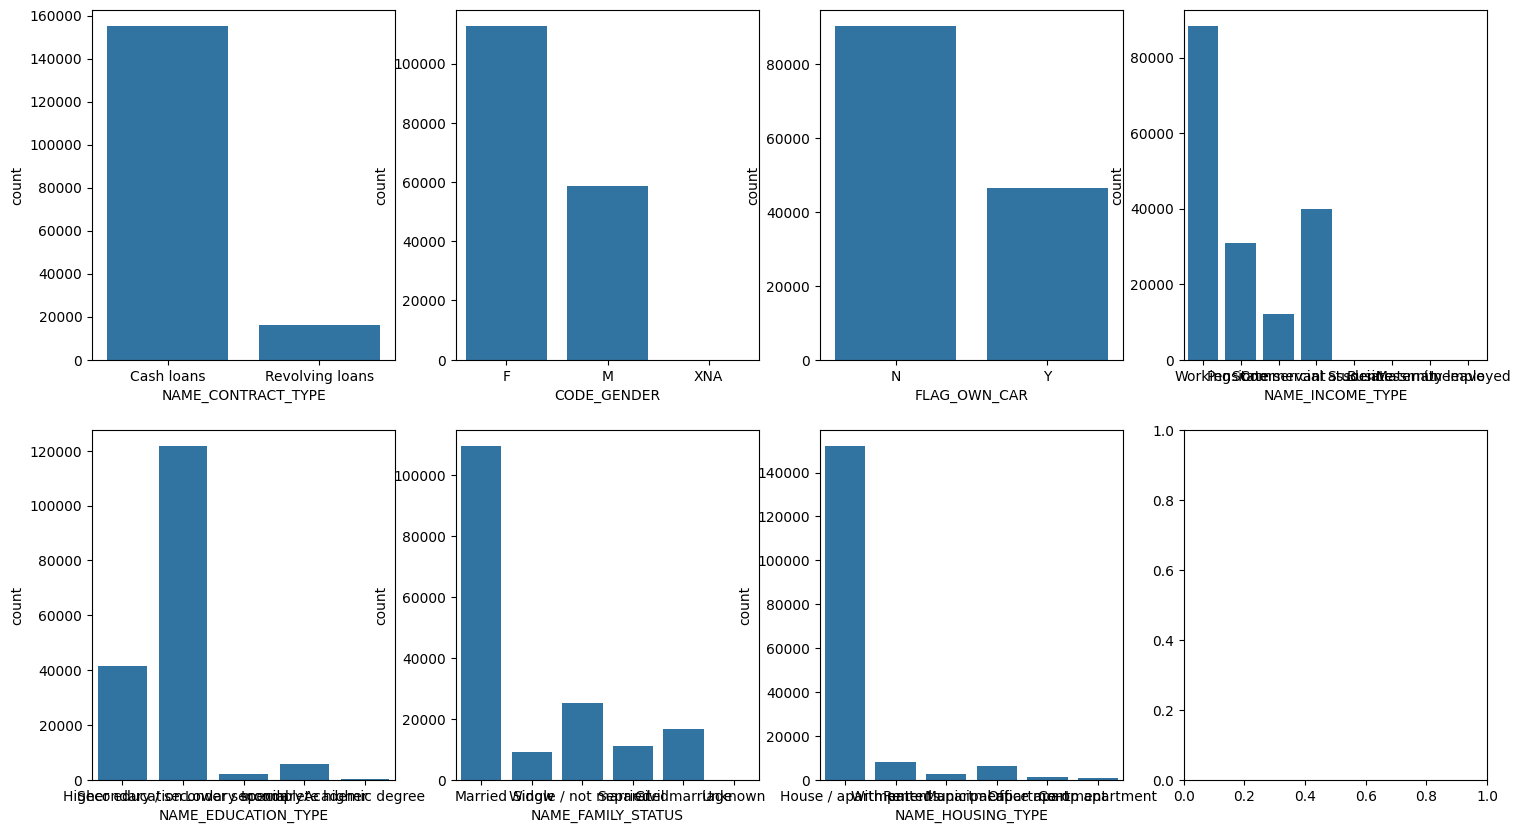

In [ ]:
Nstrarray = Ndf.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(Nstrarray)))

fig , ax = plt.subplots(2 , 4 , figsize = (18 , 10))

for i in range(7):
    row = i // 4
    col = i % 4

    sns.countplot(data = Ndf, x = Ndf[Nstrarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(Nstrarray[i])))
plt.show()

In [ ]:
list(Ntest.select_dtypes("int").columns)
list(Ntest.select_dtypes("float").columns)

['AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_Percentage']

명목형 데이터 특성 개수 : 9


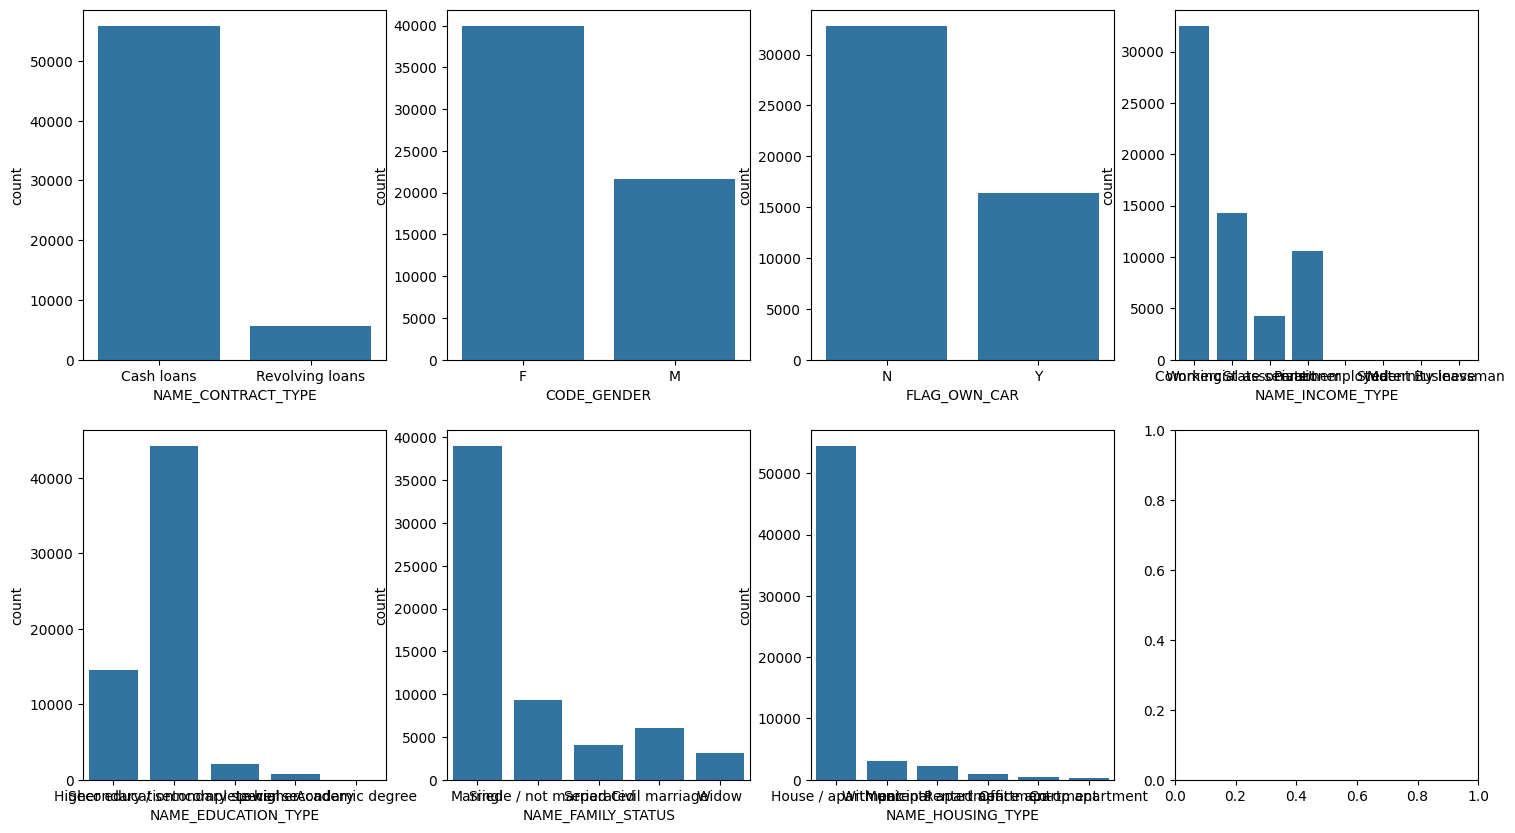

In [ ]:
Nstrarray = Ntest.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(Nstrarray)))

fig , ax = plt.subplots(2 , 4 , figsize = (18 , 10))

for i in range(7):
    row = i // 4
    col = i % 4

    sns.countplot(data = Ntest, x = Ntest[Nstrarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(Nstrarray[i])))
plt.show()

In [ ]:
I =list(Ntest.select_dtypes("int").columns)
F = list(Ntest.select_dtypes("float").columns)
numcolumns = I+F


In [ ]:

removecolumns = ["SK_ID_CURR","REGION_POPULATION_RELATIVE",'FLAG_WORK_PHONE',
                 'REGION_RATING_CLIENT_W_CITY','REG_CITY_NOT_LIVE_CITY','CNT_FAM_MEMBERS']
for i in removecolumns:
    numcolumns.remove(i)
print(len(numcolumns))

36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 67 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   SK_ID_CURR                                         171202 non-null  int64  
 1   TARGET                                             171202 non-null  int64  
 2   NAME_CONTRACT_TYPE                                 171202 non-null  int64  
 3   CODE_GENDER                                        171202 non-null  int64  
 4   FLAG_OWN_CAR                                       171202 non-null  int64  
 5   AMT_INCOME_TOTAL                                   171202 non-null  float64
 6   AMT_CREDIT                                         171202 non-null  float64
 7   AMT_ANNUITY                                        171196 non-null  float64
 8   AMT_GOODS_PRICE                                    171039 non-null  float6

In [ ]:
for i in removecolumns:
    print(Ndf[i].unique())

[     0      1      2 ... 171199 171200 171201]
[0.010032 0.008019 0.00496  0.005002 0.006296 0.018209 0.011657 0.006671
 0.010643 0.020713 0.022625 0.018029 0.072508 0.01452  0.04622  0.003818
 0.003813 0.031329 0.025164 0.002134 0.035792 0.00712  0.01885  0.002042
 0.02461  0.007114 0.026392 0.004849 0.008866 0.030755 0.008575 0.003069
 0.018634 0.010147 0.020246 0.00702  0.019101 0.016612 0.010966 0.019689
 0.018801 0.028663 0.005144 0.006305 0.007305 0.010006 0.006008 0.015221
 0.009334 0.009175 0.0228   0.009549 0.002506 0.011703 0.00733  0.008625
 0.008474 0.00963  0.006852 0.008068 0.005313 0.032561 0.003122 0.006629
 0.006233 0.010556 0.006207 0.009657 0.00823  0.014464 0.0105   0.005084
 0.007274 0.010276 0.001417 0.001276 0.003541 0.001333 0.000938 0.000533
 0.00029 ]
[1 0]
[2 3 1]
[0 1]
[ 2.  1.  3.  4.  5.  6.  7.  8. 11. nan 12.  9. 14. 10. 15. 16.]


int or float columns : 36


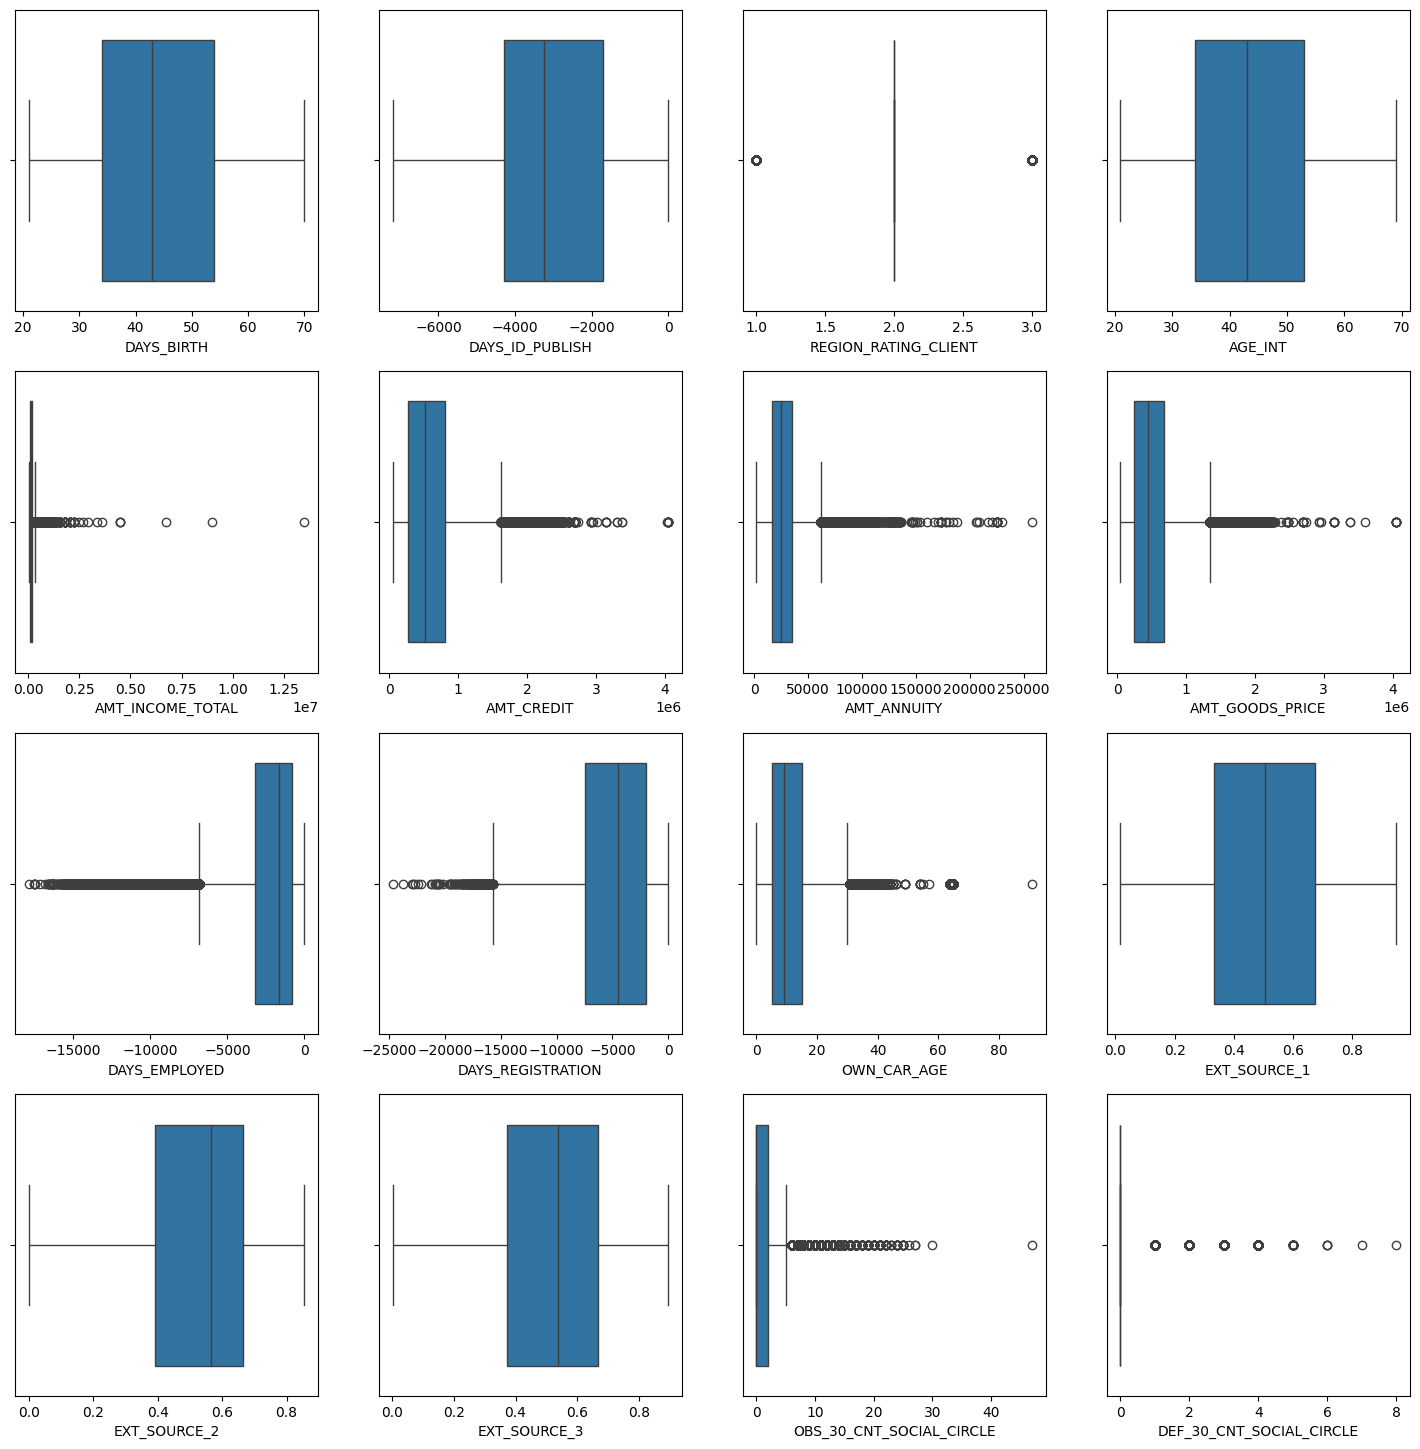

In [ ]:
print("int or float columns : {}".format(len(numcolumns)))

fig , ax = plt.subplots(4 , 4 , figsize = (18 , 18))

for i in range(16):
    row = i // 4
    col = i % 4

    sns.boxplot(data = Ndf, x = Ndf[numcolumns[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(numcolumns[i])))
plt.show()

int or float columns : 16


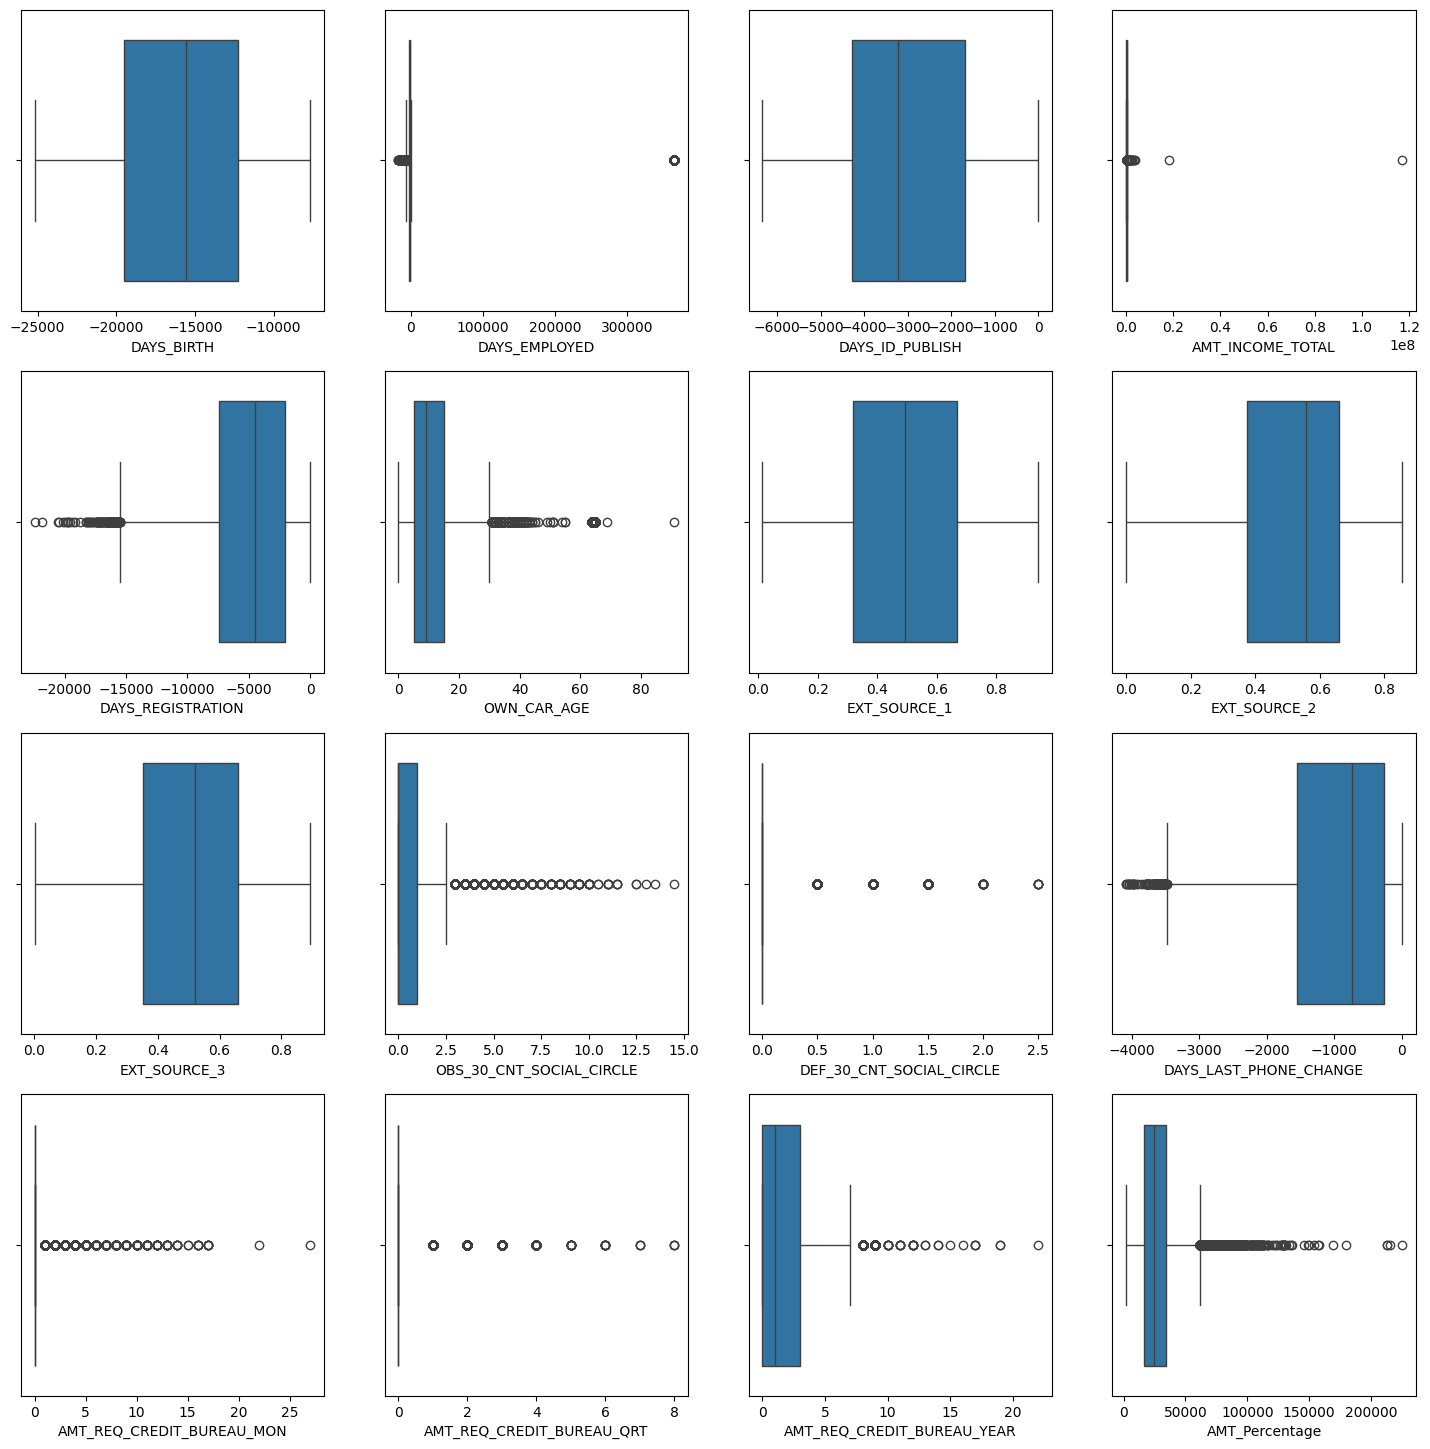

In [ ]:
print("int or float columns : {}".format(len(numcolumns)))

fig , ax = plt.subplots(4 , 4 , figsize = (18 , 18))

for i in range(16):
    row = i // 4
    col = i % 4

    sns.boxplot(data = Ntest, x = Ntest[numcolumns[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(numcolumns[i])))
plt.show()

<Axes: xlabel='AMT_INCOME_TOTAL'>

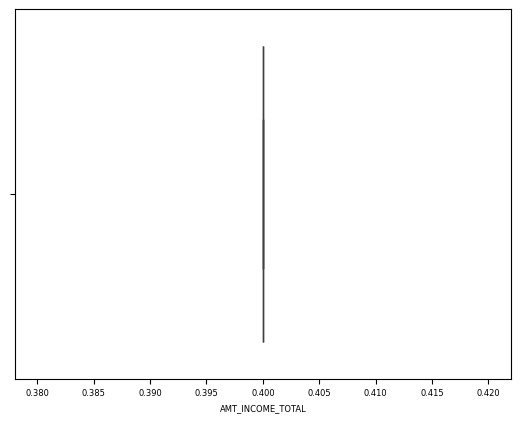

In [ ]:

sns.boxplot(data = Ntest, x = Ntest["AMT_INCOME_TOTAL"] )


<Axes: xlabel='AMT_INCOME_TOTAL'>

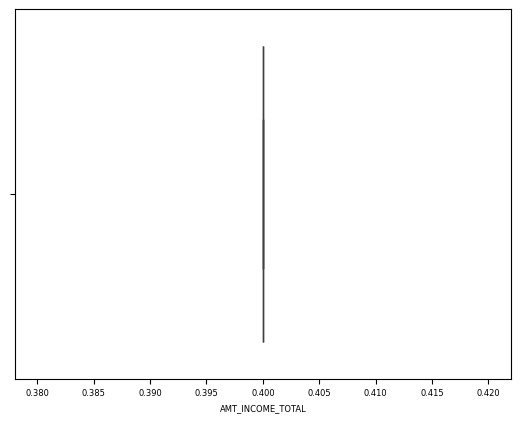

In [ ]:
sns.boxplot(data = Ndf, x = Ndf["AMT_INCOME_TOTAL"] )

In [19]:
# tukey

def tukey(data , c):
    q1 = np.percentile(data[c] , 25)
    q3 = np.percentile(data[c] , 75)

    IQR = q3 - q1

    upper_fence = q3 + 1.5 * IQR
    lower_fence = q1 - 1.5 * IQR

    return data[(data[c] < lower_fence) | (data[c] > upper_fence)]

In [20]:
outlierarray =['DAYS_EMPLOYED',
 'AMT_INCOME_TOTAL',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_Percentage']
 

In [21]:
# 비율 확인

length = Ndf.shape[0]
t_length = Ntest.shape[0]
for i in outlierarray:
    print("{0} Outlier Percentage :{1}%".format(i,round((tukey(Ndf , i).shape[0]) / length * 100 , 10)))
    print("Test {0} Outlier Percentage :{1}%".format(i,round((tukey(Ntest ,i).shape[0]) / t_length * 100,10)))


DAYS_EMPLOYED Outlier Percentage :0.0%
Test DAYS_EMPLOYED Outlier Percentage :0.0%


KeyError: 'AMT_INCOME_TOTAL'

In [26]:
# outlier
Ntest.loc[Ntest["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
Ntest['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
Ndf.loc[Ndf["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
Ndf['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)


In [22]:
print(Ndf["NAME_EDUCATION_TYPE"].unique())
print(Ntest["NAME_EDUCATION_TYPE"].unique())

['Higher education' 'Secondary / secondary special' 'Lower secondary'
 'Incomplete higher' 'Academic degree']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


In [23]:
print(Ndf["NAME_INCOME_TYPE"].unique())
print(Ntest["NAME_INCOME_TYPE"].unique())

['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Student'
 'Businessman' 'Maternity leave' 'Unemployed']
['Working' 'Commercial associate' 'State servant' 'Pensioner' 'Unemployed'
 'Student' 'Maternity leave' 'Businessman']


In [24]:

print(Ndf["NAME_HOUSING_TYPE"].unique())
print(Ntest["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']


In [25]:

print(Ndf["NAME_HOUSING_TYPE"].unique())
print(Ntest["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']


In [27]:
# CODE_GENDER
mode = Ndf["CODE_GENDER"].mode().iloc[0]
Ndf["CODE_GENDER"] = Ndf["CODE_GENDER"].replace('XNA', mode)

In [56]:
Ndf[Ndf["NAME_FAMILY_STATUS"] == "Unknown"]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_23_sum,EXT_12_sum,EXT_13_sum,EXT_123_sum,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_PRICE_RATIO
47453,47453,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,...,1.31582,NaN,NaN,NaN,-6.628571,0.346154,NaN,0.144444,20.0,NaN
74592,74592,0,Revolving loans,M,N,Y,0,450000.0,675000.0,33750.0,...,NaN,NaN,NaN,NaN,-34.147059,0.666667,NaN,0.075000,20.0,NaN


In [28]:
# NAME_FAMILY_STATUS
print(Ndf["NAME_FAMILY_STATUS"].unique())
print(Ntest["NAME_FAMILY_STATUS"].unique())
mode = Ndf["NAME_FAMILY_STATUS"].mode().iloc[0]
Ndf["NAME_FAMILY_STATUS"] = Ndf["NAME_FAMILY_STATUS"].replace('Unknown', mode)

['Married' 'Widow' 'Single / not married' 'Separated' 'Civil marriage'
 'Unknown']
['Married' 'Single / not married' 'Separated' 'Civil marriage' 'Widow']


In [29]:
# ORGANIZATION_TYPE
mode = Ndf["ORGANIZATION_TYPE"].mode().iloc[0]
Ndf["ORGANIZATION_TYPE"] = Ndf["ORGANIZATION_TYPE"].replace('XNA', mode)

Tmode = Ntest["ORGANIZATION_TYPE"].mode().iloc[0]
Ntest["ORGANIZATION_TYPE"] = Ntest["ORGANIZATION_TYPE"].replace('XNA', Tmode)

In [30]:
#2
E = LabelEncoder()
Larray = ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","ORGANIZATION_TYPE","OCCUPATION_TYPE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"]
for i in range(len(Larray)):
    Labeled = E.fit_transform(Ndf[Larray[i]])
    Ndf[Larray[i]] = Labeled
    testLabeled = E.fit_transform(Ntest[Larray[i]])
    Ntest[Larray[i]] = testLabeled
    

In [12]:
# some
ColumnsOneHot = ["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE",]
encoder = OneHotEncoder(sparse_output = False)

Ndf_encoded = pd.get_dummies(Ndf[ColumnsOneHot])

Ndf.drop(columns=ColumnsOneHot, inplace=True)
Ndf = pd.concat([Ndf, Ndf_encoded], axis=1)

Ntest_encoded = pd.get_dummies(Ntest[ColumnsOneHot])

Ntest.drop(columns=ColumnsOneHot, inplace=True)
Ntest = pd.concat([Ntest, Ntest_encoded], axis=1)

In [61]:
Ndf.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,0,0,0,0,0,N,0,112500.0,755190.0,36328.5,...,True,False,False,False,False,True,False,False,False,False
1,1,0,0,0,0,Y,0,225000.0,585000.0,16893.0,...,True,False,False,False,False,True,False,False,False,False
2,2,0,0,0,0,Y,0,54000.0,334152.0,18256.5,...,True,False,False,False,False,True,False,False,False,False
3,3,0,0,0,0,Y,0,67500.0,152820.0,8901.0,...,False,False,False,True,False,True,False,False,False,False
4,4,1,0,1,0,N,0,157500.0,271066.5,21546.0,...,True,False,False,False,False,False,False,False,False,True


In [62]:
Ndf["NAME_FAMILY_STATUS_Widow"]

0         False
1         False
2         False
3          True
4         False
          ...  
171197    False
171198    False
171199    False
171200    False
171201    False
Name: NAME_FAMILY_STATUS_Widow, Length: 171202, dtype: bool

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,0,0,0,0,0,112500.0,755190.0,36328.5,675000.0,0.010032,...,True,False,False,False,False,True,False,False,False,False
1,1,0,0,0,0,225000.0,585000.0,16893.0,585000.0,0.008019,...,True,False,False,False,False,True,False,False,False,False
2,2,0,0,0,0,54000.0,334152.0,18256.5,270000.0,0.004960,...,True,False,False,False,False,True,False,False,False,False
3,3,0,0,0,0,67500.0,152820.0,8901.0,135000.0,0.005002,...,False,False,False,True,False,True,False,False,False,False
4,4,1,0,1,0,157500.0,271066.5,21546.0,234000.0,0.006296,...,True,False,False,False,False,False,False,False,False,True


In [31]:
Ndf.drop(['FLAG_MOBIL','REG_REGION_NOT_LIVE_REGION','FLAG_CONT_MOBILE','FLAG_EMAIL',
          'FLAG_EMP_PHONE','LIVE_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION',
          'REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY','AMT_REQ_CREDIT_BUREAU_HOUR',
          'FLAG_OWN_REALTY','NAME_TYPE_SUITE','CNT_CHILDREN','FLAG_PHONE'
],axis = 1,inplace = True)

Ntest.drop(['FLAG_MOBIL','REG_REGION_NOT_LIVE_REGION','FLAG_CONT_MOBILE','FLAG_EMAIL',
          'FLAG_EMP_PHONE','LIVE_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION',
          'REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY','AMT_REQ_CREDIT_BUREAU_HOUR',
          'FLAG_OWN_REALTY','NAME_TYPE_SUITE','CNT_CHILDREN','FLAG_PHONE'],axis = 1,inplace = True)

In [32]:
columns = list(Ndf.columns)
columns.remove('TARGET')
columns.remove('SK_ID_CURR')

In [33]:

from sklearn.preprocessing import StandardScaler
X = Ndf[columns]
Y = Ndf["TARGET"]
scaler = StandardScaler()
X = scaler.fit_transform(X)
Test_X = Ntest[columns]
Test_X = scaler.transform(Test_X)

print('Original dataset shape %s' % Counter(Y))

# ランダムアンダーサンプリングの適用
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, Y)


# Oversampling
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X, Y)
df_res_smote = pd.DataFrame(X_res_smote, columns= columns)
df_res_smote['price_range'] = y_res_smote

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [35]:
# LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.1, max_depth = 3, num_leaves = 10)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, lgb_valid_pred)}")

[LightGBM] [Info] Number of positive: 11021, number of negative: 125940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5782
[LightGBM] [Info] Number of data points in the train set: 136961, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436003
[LightGBM] [Info] Start training from score -2.436003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [36]:

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, xgb_valid_pred)}")

Train Score: 0.8963840607498321
Valid Score: 0.7490453207140811


In [42]:
# パラメータ探索範囲の定義
param_dist = {
    'num_leaves': randint(6, 50),  # 6から50の間の整数
    'learning_rate': uniform(0.01, 0.3),  # 0.01から0.3の間の一様分布
    'max_depth': randint(3, 15),  # 3から15の間の整数
    'min_child_samples': randint(20, 50),  # 20から50の間の整数
    'feature_fraction': uniform(0.5, 0.5),  # 0.5から1.0の間の一様分布
    'bagging_fraction': uniform(0.5, 0.5)  # 0.5から1.0の間の一様分布
}

# LightGBM分類器の定義
lgbm = LGBMClassifier(objective='binary', metric='auc', random_state=42)

# ランダムサーチの設定
n_iter_search = 20  # 試行回数を指定

random_search = RandomizedSearchCV(
    lgbm, param_distributions=param_dist, n_iter=n_iter_search, scoring='roc_auc', cv=5, random_state=42
)

# ランダムサーチの実行
random_search.fit(X_train, y_train)

print("Best Parameters found: ", random_search.best_params_)
print("Best ROC AUC Score found: {:.4f}".format(random_search.best_score_))

[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Info] Number of positive: 8816, number of negative: 100752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7979
[LightGBM] [Info] Number of data points in the train set: 109568, number of used features: 56
[LightGBM] [Info] [binary:BoostFromSc

In [115]:
param_dist = {
    'learning_rate': uniform(0.01),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'n_estimators': randint(100, 1000),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# ランダムサーチを設定
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, scoring='accuracy', cv=3, verbose=2, n_jobs=-1, random_state=42)

# データのフィッティング
random_search.fit(X_train, y_train)

# 最適なパラメータとスコアを出力
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

# テストデータでの評価
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", test_accuracy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'colsample_bytree': np.float64(0.7388574454401138), 'learning_rate': np.float64(0.09289132169335422), 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 216, 'reg_alpha': np.float64(0.9632225394406113), 'reg_lambda': np.float64(0.012154474689816341), 'subsample': np.float64(0.9849394133538195)}
Best accuracy:  0.9197070704736597
Test accuracy:  0.9182266873046933


colsample_bytree = np.float64(0.9764353361934213), 
learning_rate = np.float64(0.09289132169335422), 
max_depth = 3, 
min_child_weight = 6, 
n_estimators = 216, 
reg_alpha = np.float64(0.9632225394406113), 
reg_lambda = np.float64(0.012154474689816341),
subsample = np.float64(0.9849394133538195)


In [116]:
param_dist = {
    'learning_rate': uniform(0.01),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'n_estimators': randint(100, 1000),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# ランダムサーチを設定
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, scoring='accuracy', cv=3, verbose=2, n_jobs=-1, random_state=0)

# データのフィッティング
random_search.fit(X_train, y_train)

# 最適なパラメータとスコアを出力
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

# テストデータでの評価
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", test_accuracy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'colsample_bytree': np.float64(0.9764353361934213), 'learning_rate': np.float64(0.02394839593341535), 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 328, 'reg_alpha': np.float64(0.07952208258675575), 'reg_lambda': np.float64(0.08960303423860538), 'subsample': np.float64(0.8360239036769572)}
Best accuracy:  0.9197143703295373
Test accuracy:  0.9182850968137612


In [70]:
xgb_model = XGBClassifier()

# パラメータの範囲を設定
param_grid = {
    'learning_rate': [0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 300]
}

# グリッドサーチを設定
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# データのフィッティング
grid_search.fit(X_train, y_train)

# 最適なパラメータとスコアを出力
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


KeyboardInterrupt: 

In [108]:


# データの準備（Xは特徴量、yは目的変数とする）
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのモデルを定義
model = LGBMClassifier()

# 探索するハイパーパラメータの範囲を指定
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01],
    'n_estimators': [100, 200, 500],
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'max_depth': [3,5,7],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# GridSearchCVを用いて最適なハイパーパラメータを探索
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータとそのスコアを表示
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# テストデータでの性能評価（任意）
# test_accuracy = best_model.(X_test, y_test)
# print("Test set accuracy of best model: {:.2f}".format(test_accuracy))


[LightGBM] [Info] Number of positive: 7347, number of negative: 83960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7471
[LightGBM] [Info] Number of data points in the train set: 91307, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080465 -> initscore=-2.436048
[LightGBM] [Info] Start training from score -2.436048
[LightGBM] [Info] Number of positive: 7347, number of negative: 83960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7481
[LightGBM] [Info] Number of data points in the train set: 91307, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080465 -> initscore=-2.436048
[LightGBM] [Info] Start training from score -2.436048
[LightGBM] [In

KeyboardInterrupt: 

In [37]:
# LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.09, max_depth = 7, num_leaves = 12,n_estimators = 130)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, lgb_valid_pred)}")

[LightGBM] [Info] Number of positive: 11021, number of negative: 125940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5782
[LightGBM] [Info] Number of data points in the train set: 136961, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436003
[LightGBM] [Info] Start training from score -2.436003
Train Score: 0.7854055477583997
Valid Score: 0.7605604147450782


In [38]:
train_pred = (lgb_train_pred + xgb_train_pred)/2
valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, valid_pred)}")

Train Score: 0.8676324193593079
Valid Score: 0.7606521511947547


Feature: NAME_CONTRACT_TYPE, Importance: 15
Feature: CODE_GENDER, Importance: 23
Feature: FLAG_OWN_CAR, Importance: 4
Feature: AMT_INCOME_TOTAL, Importance: 20
Feature: AMT_CREDIT, Importance: 35
Feature: AMT_ANNUITY, Importance: 46
Feature: AMT_GOODS_PRICE, Importance: 36
Feature: NAME_INCOME_TYPE, Importance: 8
Feature: NAME_EDUCATION_TYPE, Importance: 25
Feature: NAME_FAMILY_STATUS, Importance: 22
Feature: NAME_HOUSING_TYPE, Importance: 6
Feature: REGION_POPULATION_RELATIVE, Importance: 20
Feature: DAYS_BIRTH, Importance: 62
Feature: DAYS_EMPLOYED, Importance: 56
Feature: DAYS_REGISTRATION, Importance: 29
Feature: DAYS_ID_PUBLISH, Importance: 61
Feature: OWN_CAR_AGE, Importance: 34
Feature: FLAG_WORK_PHONE, Importance: 15
Feature: OCCUPATION_TYPE, Importance: 18
Feature: CNT_FAM_MEMBERS, Importance: 4
Feature: REGION_RATING_CLIENT, Importance: 2
Feature: REGION_RATING_CLIENT_W_CITY, Importance: 18
Feature: REG_CITY_NOT_LIVE_CITY, Importance: 11
Feature: ORGANIZATION_TYPE, Importance

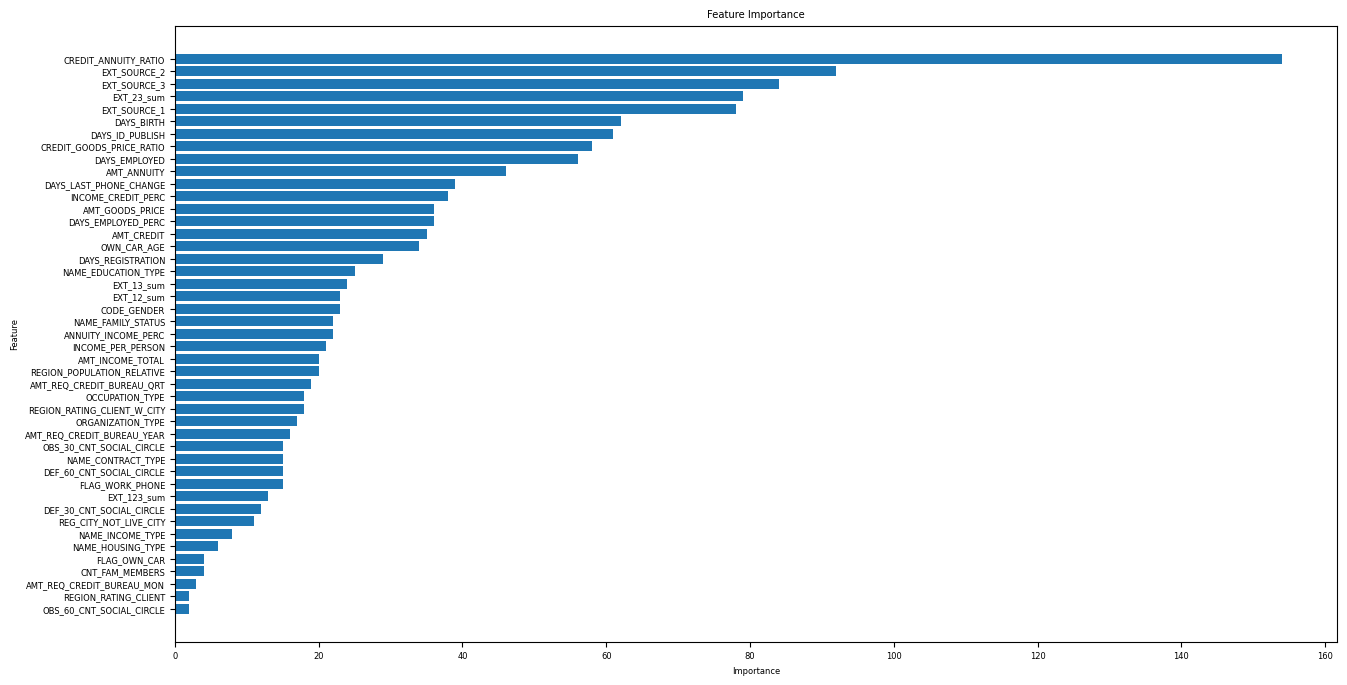

In [39]:
importance = lgb.feature_importances_
feature_names = columns
for feature, imp in zip(feature_names, importance):
    print(f"Feature: {feature}, Importance: {imp}")

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.rcParams["font.size"] = 6
plt.figure(figsize=(15, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()



In [238]:
pred = lgb.predict_proba(Test_X)[:, 1]
pred2 = xgb.predict_proba(Test_X)[:, 1]
sample_sub['TARGET'] = (pred + pred2)/2
sample_sub
sample_sub.to_csv("mix.csv", index=False)

In [239]:
sample_sub['TARGET'] = pred
sample_sub.to_csv("lgb.csv", index=False)

In [72]:

for feature, imp in zip(feature_names, importance):
    if imp==0:

        print(feature)

NAME_INCOME_TYPE_Businessman
NAME_INCOME_TYPE_Maternity leave
NAME_INCOME_TYPE_Pensioner
NAME_INCOME_TYPE_Student
NAME_INCOME_TYPE_Unemployed
NAME_EDUCATION_TYPE_Incomplete higher
NAME_FAMILY_STATUS_Single / not married
NAME_HOUSING_TYPE_Co-op apartment
NAME_HOUSING_TYPE_Municipal apartment


In [35]:
print(df_["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']


# "NAME_INCOME_TYPE"
'Working' 'State servant'  


['Pensioner','Commercial associate','Student','Businessman','Maternity leave','Unemployed']

# "NAME_EDUCATION_TYPE"
'Higher education' 'Secondary / secondary special' 'Academic degree'

['Lower secondary','Incomplete higher'] 

'House / apartment','With parents','Rented apartment','Office apartment' 

 ['Co-op apartment','Municipal apartment'] 

In [31]:
import lightgbm

In [45]:
from sklearn.metrics import accuracy_score

In [172]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    Taccuracy = accuracy_score(y_train, y_pred_train)
    accuracy = accuracy_score(y_test, y_pred)
    print(Taccuracy)
    print(accuracy)
    return accuracy

In [173]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)


[I 2024-07-02 21:48:57,714] A new study created in memory with name: no-name-32ed9bb4-652c-44ff-8094-3796014f8ddb
[W 2024-07-02 21:48:59,141] Trial 0 failed with parameters: {'lambda_l1': 0.19564744960742103, 'lambda_l2': 4.137130805707527e-07, 'num_leaves': 28, 'learning_rate': 0.2620057067063062, 'feature_fraction': 0.9046865601948756, 'bagging_fraction': 0.8913675339790956, 'bagging_freq': 7, 'min_child_samples': 31} because of the following error: NameError("name 'accuracy_score' is not defined").
Traceback (most recent call last):
  File "c:\Users\abeta\anaconda3\envs\forcompe\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\abeta\AppData\Local\Temp\ipykernel_7092\3841414240.py", line 21, in objective
    Taccuracy = accuracy_score(y_train, y_pred_train)
                ^^^^^^^^^^^^^^
NameError: name 'accuracy_score' is not defined
[W 2024-07-02 21:48:59,158] Trial 0 failed wi

NameError: name 'accuracy_score' is not defined

# TDF

In [75]:
pred = lgb.predict_proba(Test_X)[:, 1]
predlgb = lgb.predict_proba(X)[:, 1]

In [42]:
tdf = Ndf.copy()
ttest = Ntest.copy()
tdf = tdf.dropna(axis=1)
ttest = ttest.dropna(axis = 1)

In [50]:
null_counts = tdf.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

Series([], dtype: int64)


In [51]:
null_counts = ttest.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

Series([], dtype: int64)


<Axes: >

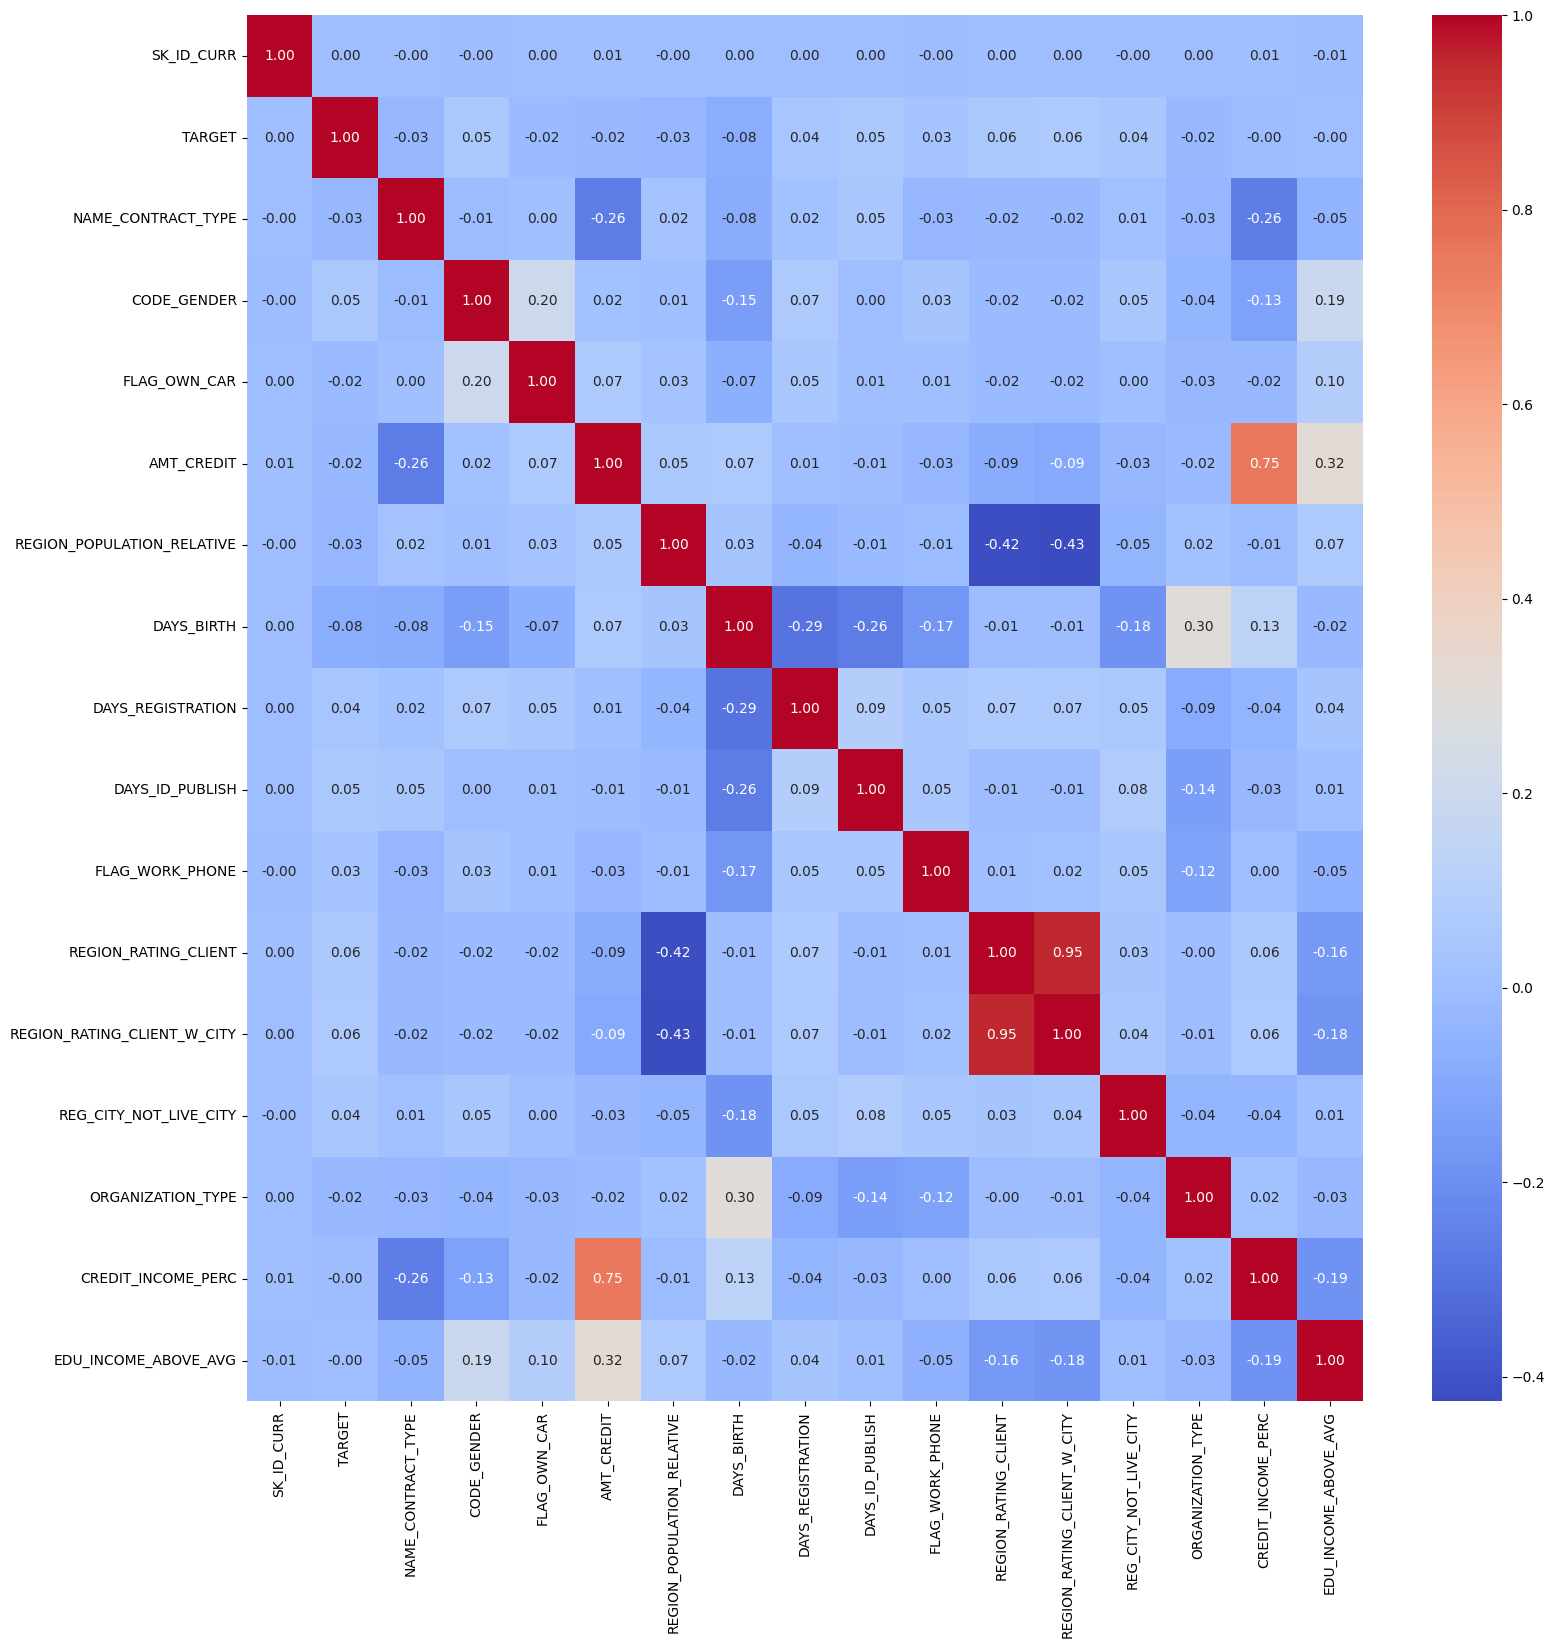

In [63]:

plt.figure(figsize=(18, 18))

sns.heatmap(data = tdf.select_dtypes(['int' , 'float']).corr('spearman'),
            annot = True ,
            fmt = '.2f' ,
            
            cmap = 'coolwarm')

In [44]:
tdf.drop(["AGE_INT","INCOME_TOTAL_CREDIT",
          "INCOME_STD"],axis = 1,inplace = True)
ttest.drop(["AGE_INT","INCOME_TOTAL_CREDIT",
          ],axis = 1,inplace = True)

In [35]:
tdf.drop("INCOME_STD",axis = 1, inplace = True)

In [48]:
tdf

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,NAME_INCOME_TYPE_State servant,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married
0,0,0,0,0,0,755190.0,0.010032,-333.0,-522,1,2,0,0.509109,False,True,False,True
1,1,0,0,0,0,585000.0,0.008019,-4469.0,-3436,0,2,0,0.521889,False,False,True,True
2,2,0,0,0,0,334152.0,0.004960,-3640.0,-2050,1,2,0,0.518505,True,False,True,True
3,3,0,0,0,0,152820.0,0.005002,-4950.0,-3951,0,3,0,0.521889,False,False,False,False
4,4,1,0,1,0,271066.5,0.006296,-5101.0,-3226,1,3,0,0.521889,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171197,171197,0,0,1,2,404325.0,0.031329,-11581.0,-3689,1,2,0,0.521606,False,False,True,True
171198,171198,0,0,0,1,601470.0,0.010006,-4629.0,-1773,0,1,0,0.493699,False,False,True,False
171199,171199,0,0,0,0,1237684.5,0.006629,-4858.0,-3393,0,2,0,0.509109,True,True,False,True
171200,171200,0,0,1,1,239850.0,0.009657,-3318.0,-1176,0,2,1,0.521889,False,False,True,False


In [76]:
tdf["lgb"] = predlgb
ttest["lgb"] = pred

In [77]:
columns = list(tdf.columns)
columns.remove('TARGET')
columns.remove('SK_ID_CURR')

In [78]:

from sklearn.preprocessing import MinMaxScaler
tX = tdf[columns]
tY = tdf["TARGET"]

tX = np.log1p(tX)

tTest_X = ttest[columns]
tTest_X = np.log1p(tTest_X)

In [79]:
null_counts = tX.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

DAYS_REGISTRATION    171100
DAYS_ID_PUBLISH      171162
dtype: int64


In [57]:
null_counts = tTest_X.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

DAYS_REGISTRATION    61458
DAYS_ID_PUBLISH      61480
dtype: int64


In [80]:
tX.drop(["DAYS_REGISTRATION","DAYS_ID_PUBLISH"],axis = 1,inplace = True)
tTest_X.drop(["DAYS_REGISTRATION","DAYS_ID_PUBLISH"],axis = 1,inplace = True)

Resampled dataset shape Counter({0: 13821, 1: 13821})


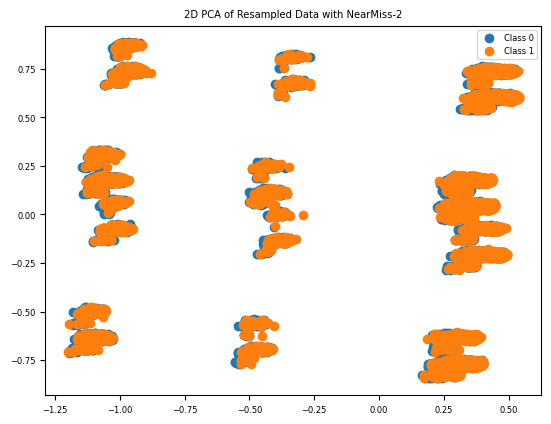

In [171]:

from imblearn.under_sampling import NearMiss
# NearMiss-2の適用
nm2 = NearMiss(version=3)  # NearMissのバージョンを2に設定
X_res, y_res = nm2.fit_resample(tX,tY)

# アンダーサンプリング後のデータのクラス分布の確認
print('Resampled dataset shape %s' % Counter(y_res))

# データの可視化（オプション）
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_res_pca = pca.fit_transform(X_res)
plt.scatter(X_res_pca[y_res == 0, 0], X_res_pca[y_res == 0, 1], label='Class 0')
plt.scatter(X_res_pca[y_res == 1, 0], X_res_pca[y_res == 1, 1], label='Class 1')
plt.legend()
plt.title('2D PCA of Resampled Data with NearMiss-2')
plt.show()

In [172]:
tX_train, tX_test, ty_train, ty_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [81]:
tX_train, tX_test, ty_train, ty_test = train_test_split(tX, tY, test_size=0.2, random_state=42)

In [82]:
et  = ExtraTreesClassifier()
et.fit(tX_train, ty_train)

et_train_pred = et.predict_proba(tX_train)[:, 1]
et_valid_pred = et.predict_proba(tX_test)[:, 1]
print(f"Train Score: {roc_auc_score(ty_train, et_train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, et_valid_pred)}")


Train Score: 1.0
Valid Score: 0.7076015280320964


In [83]:
lr = LogisticRegression(random_state=0)
lr.fit(tX_train, ty_train)

lr_train_pred = lr.predict_proba(tX_train)[:, 1]
lr_valid_pred = lr.predict_proba(tX_test)[:, 1]
print(f"Train Score: {roc_auc_score(ty_train, lr_train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, lr_valid_pred)}")

Train Score: 0.7806504731456918
Valid Score: 0.7600913048021919


In [84]:
GBC = GradientBoostingClassifier(max_depth = 4,subsample = 0.5374697790412601,min_samples_leaf= 20)
GBC.fit(tX_train, ty_train)
GBC_train_pred = GBC.predict_proba(tX_train)[:, 1]
GBC_valid_pred = GBC.predict_proba(tX_test)[:, 1]
print(f"Train Score: {roc_auc_score(ty_train, GBC_train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, GBC_valid_pred)}")

Train Score: 0.7930936477731017
Valid Score: 0.7613609618014695


In [50]:
gbc_pred = GBC.predict_proba(tX)[:, 1]
gbc_pred

array([0.12198816, 0.02721095, 0.15511857, ..., 0.01292818, 0.02436558,
       0.08266243])

In [59]:
lrpred = lr.predict_proba(tTest_X)[:, 1]

In [219]:
Ndf["gbc_pred"] = lr_pred
Ntest["gbc_pred"] = pred3

In [ ]:
print(f"Train ROC AUC Score: {train_roc_auc}")
print(f"Test ROC AUC Score: {test_roc_auc}")

Train ROC AUC Score: 0.6533243335485335
Test ROC AUC Score: 0.6619799862708865


In [200]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
}

gbc = GradientBoostingClassifier()

# GridSearchCVの例
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


# トレーニングデータでフィッティング
grid_search.fit(X_train, y_train)

# 最適なパラメータの表示
print("Best parameters found by GridSearchCV:", grid_search.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 

In [52]:
MLP = MLPClassifier()
MLP.fit(tX_train, ty_train)
MLP_train_pred = MLP.predict_proba(tX_train)[:, 1]
MLP_valid_pred = MLP.predict_proba(tX_test)[:, 1]
print(f"Train Score: {roc_auc_score(ty_train,MLP_train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, MLP_valid_pred)}")

Train Score: 0.7883925942874559
Valid Score: 0.759165125609418


In [ ]:
tY[tY == 0]

0        0
1        0
2        0
3        0
4        0
        ..
13816    0
13817    0
13818    0
13819    0
13820    0
Name: TARGET, Length: 13821, dtype: int64

In [ ]:
tY[tY == 1]

13821    1
13822    1
13823    1
13824    1
13825    1
        ..
27637    1
27638    1
27639    1
27640    1
27641    1
Name: TARGET, Length: 13821, dtype: int64

In [ ]:
tX

array([[0.01142208, 0.1011236 , 0.42857143, ..., 0.        , 1.        ,
        0.        ],
       [0.01142208, 0.06952809, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.02144145, 0.04494382, 0.14285714, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.01810166, 0.17721348, 0.42857143, ..., 0.        , 0.        ,
        0.        ],
       [0.00808229, 0.12471685, 0.42857143, ..., 1.        , 0.        ,
        1.        ],
       [0.0064124 , 0.04026966, 1.        , ..., 0.        , 1.        ,
        0.        ]])

DecisionTreeClassifier,
KNeighborsClassifier,AdaBoostClassifier,
RandomForestClassifier,VotingClassifier,

In [86]:
train_pred = (lgb_train_pred + xgb_train_pred + GBC_train_pred)/3
valid_pred = (lgb_valid_pred + xgb_valid_pred + GBC_valid_pred)/3

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, valid_pred)}")

Train Score: 0.8528375773065054
Valid Score: 0.7627654291257548


In [85]:
train_pred = (GBC_train_pred+ lr_train_pred + lgb_train_pred + xgb_train_pred )/4
valid_pred = (GBC_valid_pred + lr_valid_pred + lgb_valid_pred + xgb_valid_pred )/4

print(f"Train Score: {roc_auc_score(ty_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(ty_test, valid_pred)}")

Train Score: 0.84362033331865
Valid Score: 0.7633546052242977


In [ ]:
print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Best hyperparameters:", trial.params)


Best trial:
Accuracy: 0.9186647586227038
Best hyperparameters: {'lambda_l1': 0.00035240278276659967, 'lambda_l2': 3.3602464271941526, 'num_leaves': 84, 'learning_rate': 0.05337961575790194, 'feature_fraction': 0.539258644115885, 'bagging_fraction': 0.7243925148353267, 'bagging_freq': 4, 'min_child_samples': 23}


In [221]:
pred3 = GBC.predict_proba(tTest_X)[:, 1]
sample_sub['TARGET'] = pred3
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.394220
1,171203,0.514811
2,171204,0.447782
3,171205,0.536115
4,171206,0.494965
...,...,...
61495,232697,0.424088
61496,232698,0.463253
61497,232699,0.588704
61498,232700,0.508841


In [31]:
print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Best hyperparameters:", trial.params)


Best trial:
Accuracy: 0.9186647586227038
Best hyperparameters: {'lambda_l1': 0.00035240278276659967, 'lambda_l2': 3.3602464271941526, 'num_leaves': 84, 'learning_rate': 0.05337961575790194, 'feature_fraction': 0.539258644115885, 'bagging_fraction': 0.7243925148353267, 'bagging_freq': 4, 'min_child_samples': 23}


In [222]:

pred2 = xgb.predict_proba(Test_X)[:, 1]

In [106]:
pred2

array([0.03305323, 0.17087871, 0.14144526, ..., 0.03088835, 0.12699345,
       0.04986493], dtype=float32)

In [87]:
pred = lgb.predict_proba(Test_X)[:, 1]
pred2 = xgb.predict_proba(Test_X)[:, 1]
pred3 = lr.predict_proba(tTest_X)[:, 1]
pred4 = GBC.predict_proba(tTest_X)[:, 1]
sample_sub['TARGET'] = (pred + pred2 + pred3 + pred4)/4
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.037040
1,171203,0.176665
2,171204,0.119845
3,171205,0.093616
4,171206,0.177656
...,...,...
61495,232697,0.159435
61496,232698,0.035868
61497,232699,0.061332
61498,232700,0.133809


In [88]:
sample_sub.to_csv("MIX.csv", index=False)


# ORGANIZATION_TYPE

# site

https://toshikishimizu.hatenablog.com/entry/2018/09/16/113851#%E3%82%B3%E3%83%B3%E3%83%9A%E3%81%AE%E6%A6%82%E8%A6%81

https://data-analysis-stats.jp/kaggle/kaggle1%e4%bd%8d%e3%81%ae%e8%a7%a3%e6%9e%90%e6%89%8b%e6%b3%95%e3%80%80%e3%80%8chome-credit-default-risk-%e5%82%b5%e5%8b%99%e4%b8%8d%e5%b1%a5%e8%a1%8c%e3%81%ae%e4%ba%88%e6%b8%ac%e3%80%8d%e2%91%a1/

https://www.kaggle.com/code/ogrellier/good-fun-with-ligthgbm

In [ ]:
# heatmap
#smote
#parameter tuning